In [1]:
from tensorflow.keras.datasets import mnist
import torchvision
from torchvision import transforms
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from time import time

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC

## Preparing Data

### Loading in, normalizing, and separating data by class

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [4]:
# What is being done here:
# We are collecting all the images by classes
# Each entry in the 'digits' list is 
# a numpy array of all the images by class

digits = []
test_digits = []
for i in range(10):
    classno = X_train[np.where(y_train==i)]
    digits.append(classno)
    classno = X_test[np.where(y_test==i)]
    test_digits.append(classno)

### Generating Adversarial Samples

In [24]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Epoch 0 - Training loss: 0.3384237220522755
Epoch 1 - Training loss: 0.14074472397236204
Epoch 2 - Training loss: 0.09490377420156415
Epoch 3 - Training loss: 0.07069361007321617
Epoch 4 - Training loss: 0.05609943824130168
Epoch 5 - Training loss: 0.04491932405757585
Epoch 6 - Training loss: 0.035314020599292686
Epoch 7 - Training loss: 0.02895237960262415
Epoch 8 - Training loss: 0.02373877125603558
Epoch 9 - Training loss: 0.02237127911877696
Epoch 10 - Training loss: 0.017248572427223424
Epoch 11 - Training loss: 0.014852242318924883
Epoch 12 - Training loss: 0.01547639733332904
Epoch 13 - Training loss: 0.011558917917664812
Epoch 14 - Training loss: 0.01203490065390162

Training Time (in minutes) = 0.35636666615804036
Predicted Digit = 4
Number Of Images Tested = 10000

Model Accuracy = 0.9776


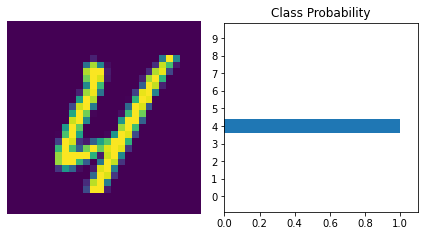

In [6]:
# Now let's start training the network

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

def train_model(model, x_train, x_test, y_train, y_test, epochs=15):
    transform = transforms.Compose([transforms.Normalize((0,), (1,)),])
    
    #trainset = datasets.MNIST('../', download=True, train=True, transform=transform)
    #valset = datasets.MNIST('../', download=True, train=False, transform=transform)
    trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.long))
    valset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    criterion = nn.NLLLoss()
    images, labels = next(iter(trainloader))
    images = images.view(images.shape[0], -1)
    labels = labels

    logps = model(images)
    loss = criterion(logps, labels)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:

            images = images.view(images.shape[0], -1)
            labels = labels

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)


    images, labels = next(iter(valloader))

    img = images[0].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

    correct_count, all_count = 0, 0
    for images,labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)


            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    
    return model
    
model = train_model(model, X_train, X_test, y_train, y_test, epochs=15)

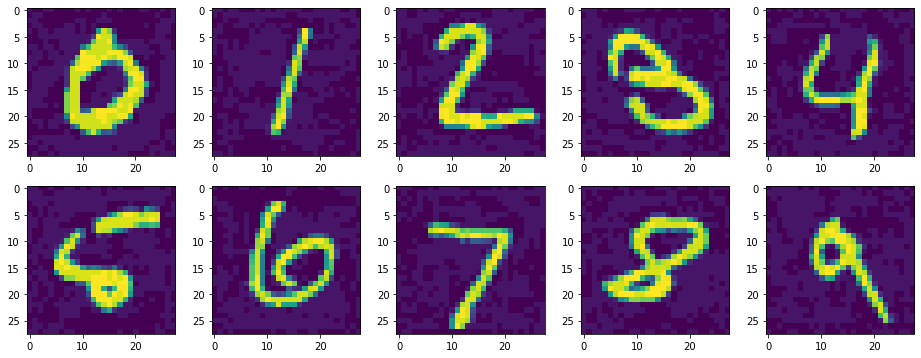

In [7]:
# Let's create adversarial examples
def get_adv_digits(clean_digits, model, eps=1e-5):
    adv_digits = list()
    for i in range(10):
        adv_digits.append(fast_gradient_method(model, torch.from_numpy(clean_digits[i]), eps, np.inf).detach().numpy())
    return adv_digits

def display_digits(adv_digits):
    fig, axes = plt.subplots(nrows=2, ncols=5)
    fig.set_figheight(6)
    fig.set_figwidth(16)
    for digit in range(10):
        row = int(digit / 5.0)
        col = digit % 5
        axes[row][col].imshow(adv_digits[digit][0].reshape(28,28))
    plt.show()

epsilon = 3e-2
adv_digits =  get_adv_digits(digits, model, eps=epsilon)
adv_digits_test = get_adv_digits(test_digits, model, eps=epsilon)

display_digits(adv_digits_test)

Number Of Images Tested = 10000

Model Accuracy = 0.5068

Number of misclassified images with high model confidence =  3214


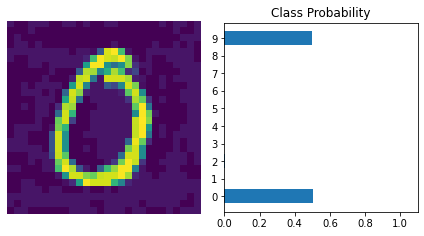

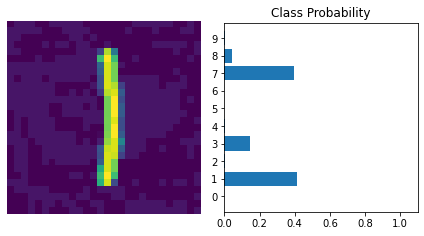

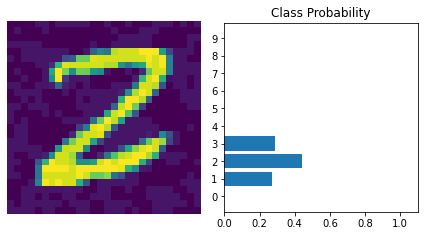

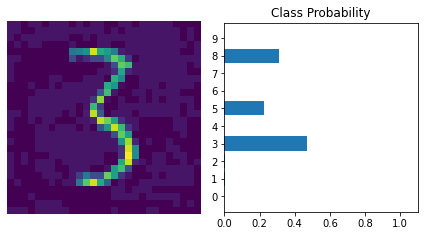

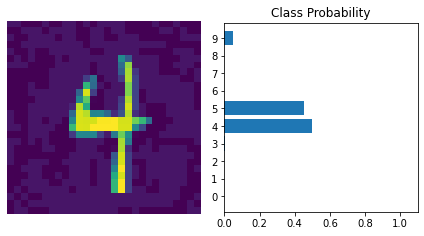

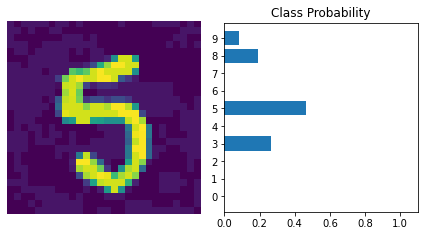

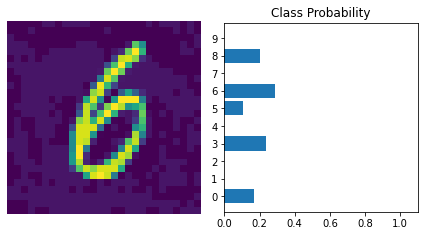

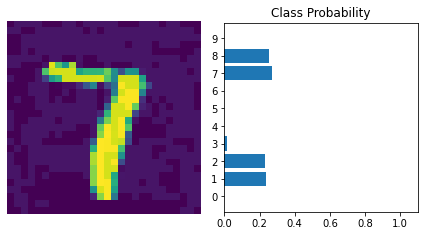

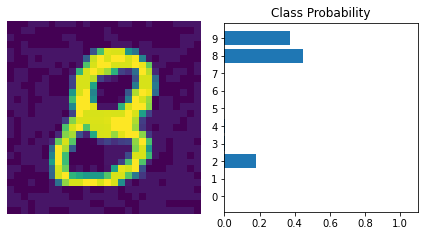

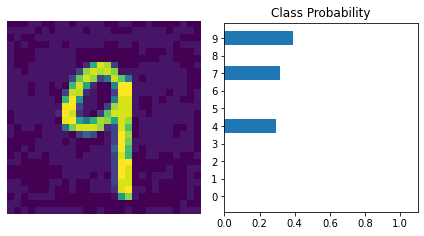

In [8]:
def eval_model(model, digits):
    correct_count, all_count, high_prob_misclassification_count = 0, 0, 0
    least_certain_idx = [0 for i in range(10)]
    least_certain_probs = [np.zeros((10), dtype=float) for i in range(10)]
    
    for digit in range(10):
        least_certain = 1
        for i in range(len(digits[digit])):
            img = torch.from_numpy(digits[digit][i]).unsqueeze(axis=0) # Create tensor with batch dimension
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            if (digit == pred_label):
                correct_count += 1
                if probab[digit] < least_certain:
                    least_certain = probab[digit]
                    least_certain_idx[digit] = i
                    least_certain_probs[digit] = ps
            elif (ps.max().item() >= .95):
                    high_prob_misclassification_count += 1
            all_count += 1
    
    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    print("\nNumber of misclassified images with high model confidence = ", (high_prob_misclassification_count))
    
    for i in range(10):
        view_classify(torch.from_numpy(digits[i][least_certain_idx[i]]).unsqueeze(axis=0), least_certain_probs[i])
        
eval_model(model, adv_digits_test)

In [9]:
def one_vs_all_network_outputs(data, labels, network, digit):
    """ Function to return the network outputs of images belonging to a particular digit
        vs network outputs of images belonging to all other classes. Images of the digit 
        passed in as the fourth parameter are labeled 1 and images of all other digits 
        are labeled 0.
    """
    curr_digit = data[np.where(labels==digit)]
    other_digits = data[np.where(labels!=digit)]
    
    labels = np.concatenate((np.zeros((len(other_digits)), dtype=int), 
                             np.ones((len(curr_digit)), dtype=int)))
    
    train = np.concatenate((other_digits, curr_digit))
    
    trainset = torch.utils.data.TensorDataset(torch.Tensor(train), torch.Tensor(labels).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
    
    network_outputs = list()
    labels = list()
    with torch.no_grad():
        for x, y in trainloader:
            network_outputs.append(network(x))
            labels.append(y)
            
    network_outputs = np.concatenate(network_outputs)
    labels = np.concatenate(labels)
    
    return network_outputs, labels

### Plotting one-vs-all network outputs in TSNE plot

In [10]:
curr_digit = 0
train, train_labels = one_vs_all_network_outputs(X_train, y_train, model, curr_digit)
test, test_labels = one_vs_all_network_outputs(X_test, y_test, model, curr_digit)

In [11]:
tsne_points = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(test)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


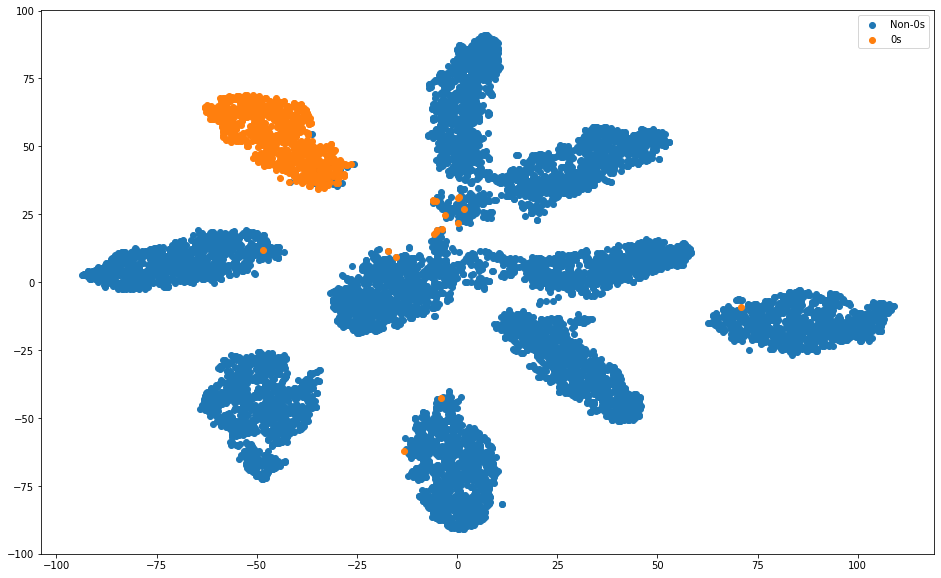

In [12]:
other_digits_idx = np.where(test_labels == 0)
current_digit_idx = np.where(test_labels == 1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_points[other_digits_idx,0], tsne_points[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_points[current_digit_idx,0], tsne_points[current_digit_idx,1], label=str(curr_digit) + "s")
plt.legend()

# Once we have created the tsne points, we plot them and try to figure out what the SVM plane looks like 

In [13]:
curr_digit = 0

train, train_labels = one_vs_all_network_outputs(X_train, y_train, model, curr_digit)
#test, test_labels = one_vs_all_network_outputs(X_test, y_test, model, digit)

tsne = TSNE(n_components=2, perplexity = 50, n_iter = 2000)
tsne_train_points = tsne.fit_transform(train)
#tsne_test_points = tsne.fit_transform(test)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


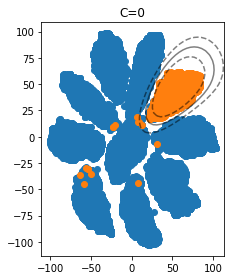

In [14]:
# rbf kernel seems to both classify the points best and encircle the cluster effectively
#clf = LinearSVC(loss='hinge', random_state=42, max_iter = 1e5).fit(tsne_train_points, train_labels)
#clf = SVC(kernel='poly', degree=3, C=1, random_state=42, max_iter = 1e5).fit(tsne_train_points, train_labels)
clf = SVC(kernel='rbf', C=1, random_state=42, max_iter = 1e5).fit(tsne_train_points, train_labels)
#clf = SVC(kernel='sigmoid', C=1, random_state=42, max_iter = 1e5).fit(tsne_train_points, train_labels)

decision_function = clf.decision_function(tsne_train_points)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = tsne_train_points[support_vector_indices]

other_digits_idx = np.where(train_labels == 0)
current_digit_idx = np.where(train_labels == 1)

plt.subplot(1, 2, 1)
plt.scatter(tsne_train_points[other_digits_idx, 0], tsne_train_points[other_digits_idx, 1])#, cmap=plt.cm.Paired)
plt.scatter(tsne_train_points[current_digit_idx, 0], tsne_train_points[current_digit_idx, 1])#, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(
    xx,
    yy,
    Z,
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
)
# plt.scatter(
#     support_vectors[:, 0],
#     support_vectors[:, 1],
#     s=100,
#     linewidth=1,
#     facecolors="none",
#     edgecolors="k",
# )
plt.title("C=" + str(0))
    
plt.tight_layout()
plt.show()

### See where adversarial samples end up in TSNE map

In [15]:
# sample points from adversarial samples of current digit
# find network outputs of all resulting images
# run TSNE embedding on the network outputs
#     keep track of which images were of the current digit, others, or adversarial
# train SVM on TSNE embedding, generating boundary between current digit and all others
# plot the TSNE output and SVM boundary, marking the current digit images, other images, and adversarial images separately

In [16]:
num_adversarial_samples = 100
curr_digit = 1

one_v_all, one_v_all_labels = one_vs_all_network_outputs(X_train, y_train, model, curr_digit)

adv_set = torch.utils.data.TensorDataset(torch.Tensor(adv_digits[curr_digit][:num_adversarial_samples]), 
                                          torch.Tensor(np.ones((num_adversarial_samples)) * -1).type(torch.long))
adv_loader = torch.utils.data.DataLoader(adv_set, batch_size=num_adversarial_samples, shuffle=False)

with torch.no_grad():
    x, adv_labels = next(iter(adv_loader))
    adv_network_outputs = model(x)

In [17]:
one_v_all = np.concatenate((one_v_all, adv_network_outputs))
one_v_all_labels = np.concatenate((one_v_all_labels, adv_labels))

In [18]:
tsne_points = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(one_v_all)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


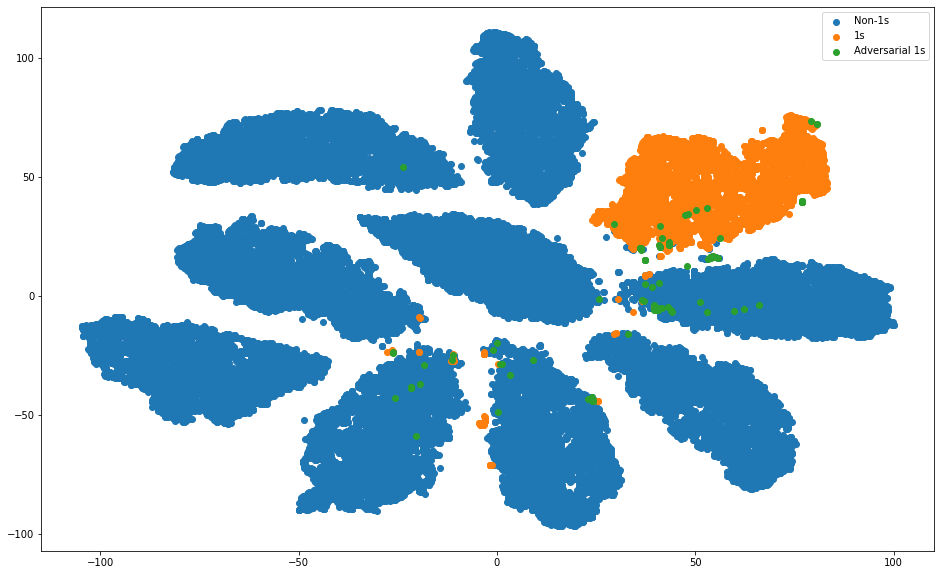

In [19]:
other_digits_idx = np.where(one_v_all_labels == 0)
current_digit_idx = np.where(one_v_all_labels == 1)
adv_images_idx = np.where(one_v_all_labels == -1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_points[other_digits_idx,0], tsne_points[other_digits_idx,1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_points[current_digit_idx,0], tsne_points[current_digit_idx,1], label=str(curr_digit) + "s")
plt.scatter(tsne_points[adv_images_idx,0], tsne_points[adv_images_idx,1], label="Adversarial " + str(curr_digit) + "s")
plt.legend()

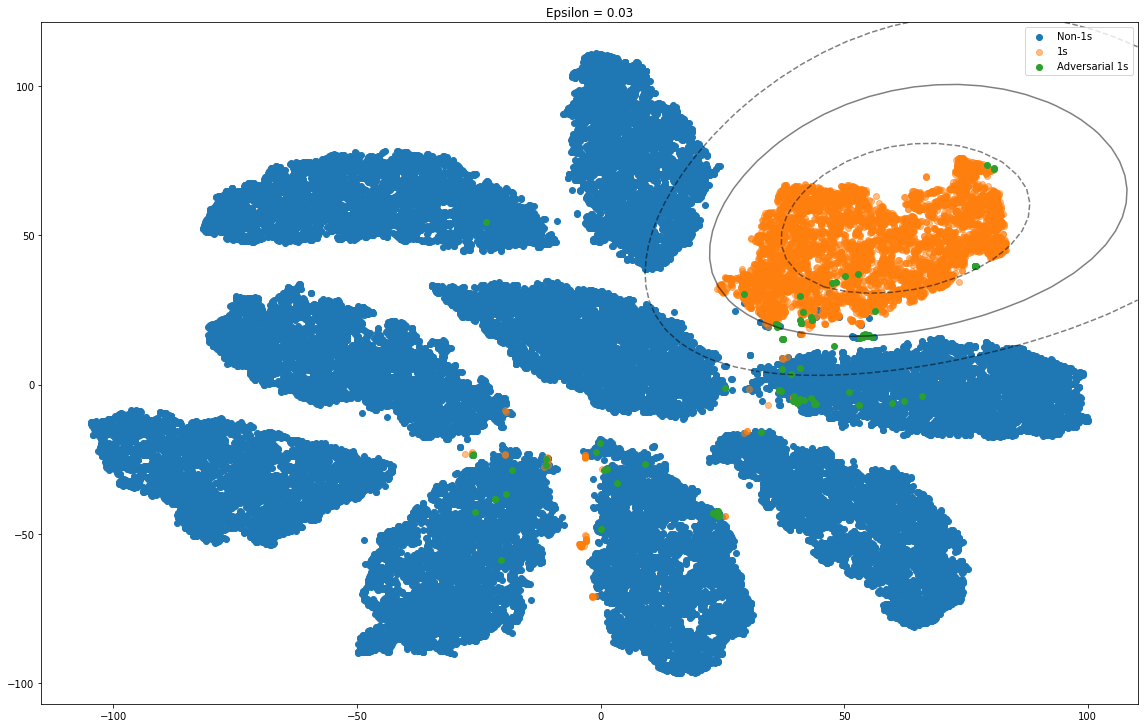

In [20]:
clean_imgs_idx = np.where(one_v_all_labels != -1)
clf = SVC(kernel='rbf', C=1e-2, random_state=42, max_iter = 1e5).fit(tsne_points[clean_imgs_idx], one_v_all_labels[clean_imgs_idx])

decision_function = clf.decision_function(tsne_points)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = tsne_points[support_vector_indices]

other_digits_idx = np.where(one_v_all_labels == 0)
current_digit_idx = np.where(one_v_all_labels == 1)
adv_images_idx = np.where(one_v_all_labels == -1)

plt.figure(figsize=(16,10))
plt.scatter(tsne_points[other_digits_idx, 0], tsne_points[other_digits_idx, 1], label="Non-" + str(curr_digit) + "s")
plt.scatter(tsne_points[current_digit_idx, 0], tsne_points[current_digit_idx, 1], label=str(curr_digit) + "s", alpha=0.5)
plt.scatter(tsne_points[adv_images_idx, 0], tsne_points[adv_images_idx, 1], label="Adversarial " + str(curr_digit) + "s")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(
    xx,
    yy,
    Z,
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
)
    
plt.tight_layout()
plt.legend()
plt.title("Epsilon = " + str(epsilon))
plt.show()